In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!unzip /content/drive/MyDrive/dataset.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/dataset/train/good/23_09_2024_10_54_55.384108_cls_input.png  
  inflating: data/dataset/train/good/23_09_2024_11_14_49.080831_cls_input.png  
  inflating: data/dataset/train/good/14_08_2024_12_33_57.462071_classifier_input.png  
  inflating: data/dataset/train/good/20_08_2024_17_54_37.235663_classifier_input.png  
  inflating: data/dataset/train/good/14_10_2024_13_06_55.910370_cls_input.png  
  inflating: data/dataset/train/good/23_09_2024_11_09_56.016153_cls_input.png  
  inflating: data/dataset/train/good/28_08_2024_10_49_39.575384_cls_input.png  
  inflating: data/dataset/train/good/24_08_2024_09_53_59.503495_cls_input.png  
  inflating: data/dataset/train/good/14_08_2024_19_04_06.139794_classifier_input.png  
  inflating: data/dataset/train/good/23_09_2024_10_57_05.706044_cls_input.png  
  inflating: data/dataset/train/good/17_08_2024_18_59_53.895058_classifier_input.png  
  inflating: data/dataset/train/good/23_0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



In [ ]:
# Step 1: Hyperparameters and Configuration
batch_size = 32
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
device

device(type='cuda')

In [ ]:
data_dir = "/content/data/dataset"

In [ ]:
data_dir

'/content/data/dataset'

In [16]:
# Step 2: Data Preparation

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [18]:
# Step 3: Load Pre-trained ResNet and Modify
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features  # Get the number of features in the last layer
model.fc = nn.Linear(num_features, 2)  # Modify for binary classification
model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [19]:
# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropy for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [20]:

# Step 5: Training Loop
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy * 100:.2f}%")



Epoch 1/10, Train Loss: 0.2663, Val Loss: 0.3945, Accuracy: 83.56%
Epoch 2/10, Train Loss: 0.1091, Val Loss: 0.0917, Accuracy: 95.89%
Epoch 3/10, Train Loss: 0.0631, Val Loss: 0.0899, Accuracy: 96.46%
Epoch 4/10, Train Loss: 0.0760, Val Loss: 0.0553, Accuracy: 97.71%
Epoch 5/10, Train Loss: 0.0420, Val Loss: 0.2889, Accuracy: 88.72%
Epoch 6/10, Train Loss: 0.0905, Val Loss: 0.0336, Accuracy: 99.04%
Epoch 7/10, Train Loss: 0.0325, Val Loss: 0.0286, Accuracy: 99.33%
Epoch 8/10, Train Loss: 0.0591, Val Loss: 0.0569, Accuracy: 97.99%
Epoch 9/10, Train Loss: 0.0371, Val Loss: 0.0571, Accuracy: 98.09%
Epoch 10/10, Train Loss: 0.0227, Val Loss: 0.0274, Accuracy: 99.04%


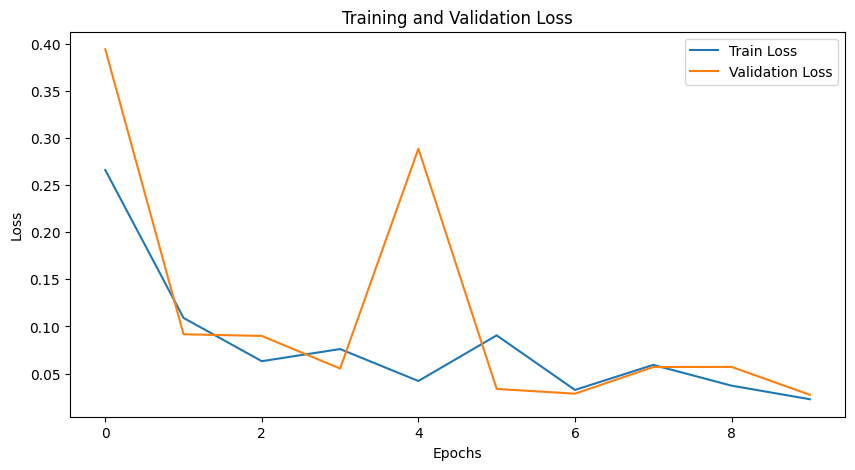

In [21]:
# Step 6: Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()



In [22]:
# Step 7: Save the Model
torch.save(model.state_dict(), "resnet_binary_classification.pth")


In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Hyperparameters and Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

# Step 2: Load Test Dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root="/content/data/dataset/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Load the Saved Model
model = models.resnet18(pretrained=False)  # Initialize ResNet
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  # 2 classes for binary classification
model.load_state_dict(torch.load("resnet_binary_classification.pth"))  # Load trained weights
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Step 4: Perform Predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get class with highest score

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 5: Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Step 6: Classification Report (Optional)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-23-00c8bd5af076>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Test Accuracy: 98.05%

Classification Report:
              precision    recall  f1-score   support

         bad       0.99      0.91      0.95       102
        good       0.98      1.00      0.99       411

    accuracy                           0.98       513
   macro avg       0.98      0.95      0.97       513
weighted avg       0.98      0.98      0.98       513



<ipython-input-27-7e28ca12de01>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_binary_classification.pth"))


Predicted Class: bad
Confidence Scores:
  bad: 100.00%
  good: 0.00%


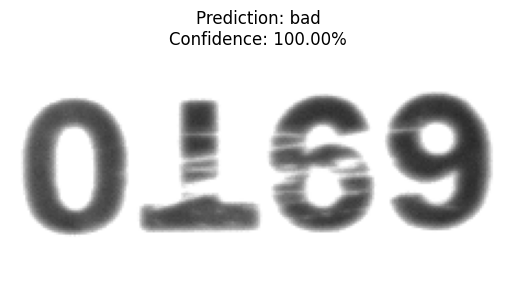

In [27]:
import torch
from torchvision import models, transforms
from PIL import Image

# Step 1: Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Load the Trained Model
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)
model.load_state_dict(torch.load("resnet_binary_classification.pth"))
model = model.to(device)
model.eval()

# Step 3: Load and Preprocess the Image
image_path = "/content/data/dataset/test/bad/03_08_2024_17_12_41.304965_classifier_input.png"
image = Image.open(image_path)

# Apply the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Add batch dimension and move to device
input_tensor = transform(image).unsqueeze(0).to(device)
# Step 4: Perform Inference
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
    predicted_class = torch.argmax(probabilities, dim=1)

class_labels = ["bad", "good"]
predicted_label = class_labels[predicted_class.item()]
confidence_scores = probabilities.squeeze().cpu().numpy()

# Display the prediction and confidence scores
print(f"Predicted Class: {predicted_label}")
print("Confidence Scores:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {confidence_scores[i] * 100:.2f}%")

# Step 6: Display the Image
plt.imshow(image)
plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_scores[predicted_class.item()] * 100:.2f}%")
plt.axis("off")
plt.show()
